# Azure Data University: mlos_bench SQLite data analysis (Teacher's copy)

In this notebook, we look at the data from 100 trials we ran in `mlos_bench` to find a better SQLite configuration.

### 1. Data collection

We used the following commands in the integrated terminal of this codespace:

```sh
conda activate mlos

mlos_bench --config "./config/cli/local-sqlite-opt.jsonc" --globals "./config/experiments/sqlite-sync-journal-pagesize-caching-experiment.jsonc" --max-iterations 100
```

> See Also: [README.md](./README.md) for further instructions.

Now we can start analyzing the autotuning data produced by running the benchmark trials.

### 2. Import packages

First, we import a few common third-party libraries for data analysis.

In [1]:
# Import a few popular third-party packages for data analysis. They come pre-installed with Anaconda.
import pandas
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Import mlos_bench Storage API to access the experimental data.
from mlos_bench.storage import from_config

In [3]:
# Cosmetic: Suppress some annoying warnings from third-party data visualization packages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 3. Connect to the DB using existing mlos_bench configs

We reuse the existing mlos_bench framework configuration file that contains the DB connection parameters. This way we make sure to connect to the same database that our framework uses to store the experimental data.

In [4]:
storage = from_config(config_file="storage/sqlite.jsonc")

### 4. Load the data for our experiment

In [5]:
storage.experiments

{'mysql-innodb-bseries-v346-vmcontrol': Experiment :: mysql-innodb-bseries-v346-vmcontrol: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-buf': Experiment :: mysql-innodb-buf: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-explore-D2S': Experiment :: mysql-innodb-explore-D2S: 'Azure MySQL+Sysbench Root',
 'sqlite-sync-journal-pagesize-caching-experiment': Experiment :: sqlite-sync-journal-pagesize-caching-experiment: 'sqlite-local-benchbase'}

We see a record for our experiment in the DB. Let's look at the data associated with it.

In [6]:
experiment_id = "sqlite-sync-journal-pagesize-caching-experiment"

### 5. Get all data for one experiment

In [7]:
exp = storage.experiments[experiment_id]
display(exp)

Experiment :: sqlite-sync-journal-pagesize-caching-experiment: 'sqlite-local-benchbase'

Main method that combines the information about each trial along with the trial configuration parameters and its results, is the property `.results`. It conveniently returns all data about the experiment is a single Pandas DataFrame.

In [8]:
# View some of the result data associated with that experiment.
df = exp.results
df.head()

,trial_id,ts_start,ts_end,config_id,status,config.cache_size,config.journal_mode,config.journal_size_limit,config.mmap_size,config.page_size,...,result.Socket messages received,result.Socket messages sent,result.Swaps,result.System time (seconds),result.Throughput (requests/second),result.User time (seconds),result.Voluntary context switches,result.isolation,result.scalefactor,result.terminals
0,0,2023-10-12 00:19:35.179108,2023-10-12 00:21:32.101952,1,SUCCEEDED,1,delete,-1,-1,4096,...,0,0,0,0.33,6.699841,2.81,14577,TRANSACTION_SERIALIZABLE,1,1
1,1,2023-10-12 00:21:32.201016,2023-10-12 00:21:46.432367,2,SUCCEEDED,1656398469,truncate,1633227268,363162755,2048,...,0,0,0,0.28,31.099798,3.37,14950,TRANSACTION_SERIALIZABLE,1,1
2,2,2023-10-12 00:21:46.494138,2023-10-12 00:22:00.870337,3,SUCCEEDED,1281136238,off,704594,779126884,2048,...,0,0,0,0.34,63.598733,3.76,15210,TRANSACTION_SERIALIZABLE,1,1
3,3,2023-10-12 00:22:00.936280,2023-10-12 00:22:15.337492,4,SUCCEEDED,948829517,wal,1120228729,1951308613,8192,...,0,0,0,0.32,63.094578,3.77,14829,TRANSACTION_SERIALIZABLE,1,1
4,4,2023-10-12 00:22:15.397273,2023-10-12 00:22:31.124095,5,SUCCEEDED,699030920,persist,2027784438,2120909557,8192,...,0,0,0,2.95,1440.387481,13.27,12883,TRANSACTION_SERIALIZABLE,1,1


Each record of the DataFrame has the information about the trial, e.g., its timestamp and status, along with the configuration parameters (columns prefixed with `config.`) and the benchmark results (columns prefixed with `result.`). Let's look at the first record to see all these fields.

In [9]:
df.loc[1]

trial_id                                                                                              1
ts_start                                                                     2023-10-12 00:21:32.201016
ts_end                                                                       2023-10-12 00:21:46.432367
config_id                                                                                             2
status                                                                                        SUCCEEDED
config.cache_size                                                                            1656398469
config.journal_mode                                                                            truncate
config.journal_size_limit                                                                    1633227268
config.mmap_size                                                                              363162755
config.page_size                                                

### 6. Plot the results

#### 6.1. Plot the behavior of the optimizer

In [10]:
# TODO:
# 1. plot of the optimizer's best config found so far (convergence rate of the optimizer)
# 2. plot of the performance of each config the optimizer found (search behavior of the optimizer)

#### 6.2. Plot the results of one metric vs. another for some tunable

The intent is to explore parameter importance and impact on different metrics (both application performance and system resource usage).

In [11]:
# Categorical tunable to consider:
CATEGORY = "config.synchronous"

# A system resource metric to analyze.
METRIC = "result.File system outputs"

# Which performance metric to plot on the Y-axis.
SCORE = "result.90th Percentile Latency (microseconds)"

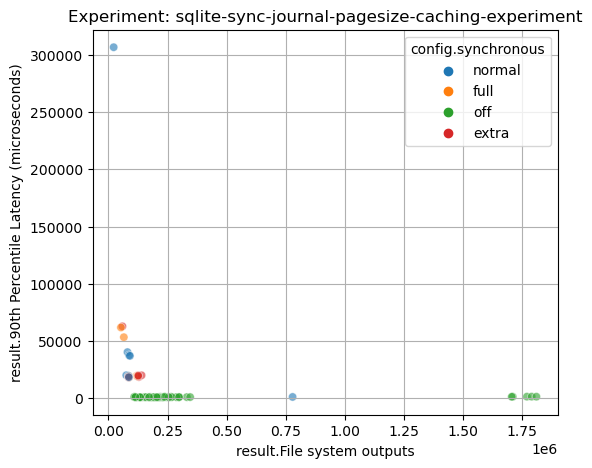

In [12]:
plt.rcParams["figure.figsize"] = (6, 5)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.6)

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()

The results are here, but the outliers make it really difficult to understand what's going on. Let's switch to the log scale and see if that helps.

#### 6.3. Plot on log scale

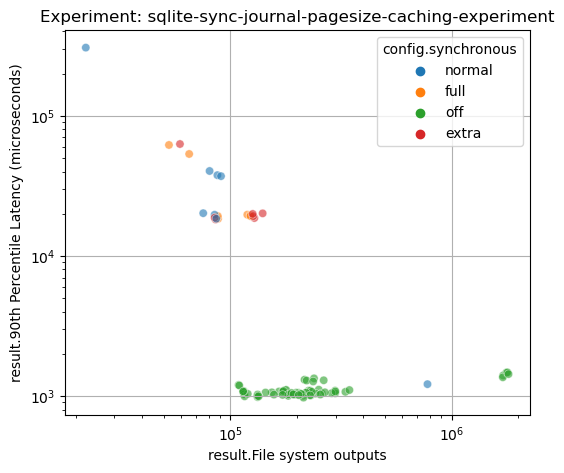

In [13]:
plt.rcParams["figure.figsize"] = (6, 5)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.6)

plt.xscale('log')
plt.yscale('log')

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()

 Now we can see that setting `synchronous=off` seems to seems to improve the latency a lot. Apparently, the optimizer had also noticed that and focused on exploring a particular area of the configuration space. Let's switch back to the linear scale and zoom in to that region.

#### 6.4. Zoom in

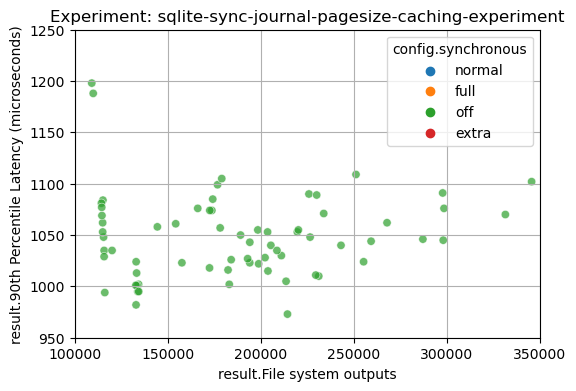

In [14]:
plt.rcParams["figure.figsize"] = (6, 4)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.7)

plt.xlim(100000, 350000)
plt.ylim(950, 1250)

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()

The latency seems to be minimal when the configuration parameter `synchronous` is set to `off` and when the metric `File system outputs` is in range of 100..300K. Let's focus on that subset of data and see what other configuration settings get us there.

#### 6.5. Look at other configuration parameters

In [15]:
df_lim = df[(df[CATEGORY] == "off") & (df[METRIC] > 100000) & (df[METRIC] < 300000)]

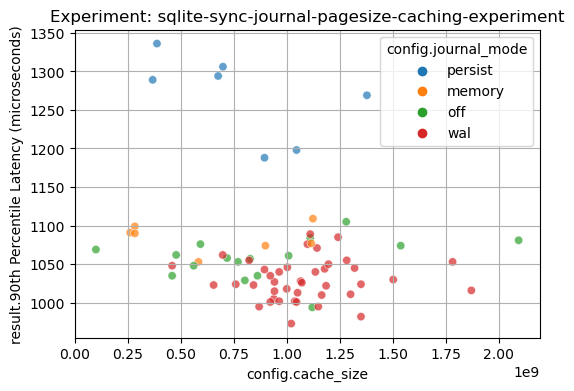

In [16]:
plt.rcParams["figure.figsize"] = (6, 4)

sns.scatterplot(data=df_lim, x="config.cache_size", y=SCORE, hue="config.journal_mode", marker='o', alpha=0.7)

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()

Again, we see that setting `journal_mode` to `wal` and `cache_size` to the value between 500MB and 2GB seem to produce good results, but we need more experiments to explore that hypothesis.

### 7. Outro

If you feel curious, please go ahead and play with the SQLite data in the cells below.

After that, please open other notebooks in this repository and explore the data you have collected in this class as well as the results from our MySQL optimization experiments:

* [**mlos_demo_sqlite.ipynb**](mlos_demo_sqlite.ipynb) - Use this notebook to analyze the data you've collected during this workshop.
* [**mlos_demo_mysql.ipynb**](mlos_demo_mysql.ipynb) - Look at the actual production data we've collected in serveral experiment for MySQL Server optimization on Azure.